In [1]:
import matplotlib.pyplot as plt
import sys

In [2]:
def find_matches_and_compress(data):
    """
    Scans the numeric data for repeated sequences (length >= 3).
    Returns a list of 'Sequence' objects: (literals, offset, match_length)
    """
    window_size = 128  # Look back distance
    min_match_len = 3  # Minimum length to consider a match
    
    sequences = []
    hash_table = {} # Maps a 3-number tuple -> index
    
    i = 0
    literal_start = 0
    n = len(data)
    
    while i < n:
        # We need at least 3 items to check for a match key
        if i + 3 > n:
            # Not enough data left for a match, just advance
            i += 1
            continue
            
        # Create a "hash key" from the next 3 numbers
        key = tuple(data[i:i+3])
        
        # Check if we've seen this pattern before
        if key in hash_table:
            match_pos = hash_table[key]
            
            # Check if match is within window distance
            if (i - match_pos) < window_size:
                # --- Match Found! Extend it. ---
                
                # 1. Determine match length
                match_len = 0
                # compare data[i + match_len] with data[match_pos + match_len]
                while (i + match_len < n) and \
                      (data[i + match_len] == data[match_pos + match_len]):
                    match_len += 1
                
                # 2. Create the Sequence
                # Grab any literals we skipped over before this match
                literals = data[literal_start : i]
                offset = i - match_pos
                
                sequences.append({
                    'literals': literals,
                    'match_len': match_len,
                    'offset': offset
                })
                
                # 3. Update Hash Table for the matched region (optional but good)
                # We add the positions we are about to skip to the hash table
                # so we can match against them later.
                for k in range(match_len):
                    if i + k + 3 <= n:
                        h_key = tuple(data[i+k : i+k+3])
                        hash_table[h_key] = i + k
                
                # 4. Advance pointers
                i += match_len
                literal_start = i
                continue

        # No match found, update hash table and move one step
        hash_table[key] = i
        i += 1

    # Flush any remaining literals at the end
    if literal_start < n:
        sequences.append({
            'literals': data[literal_start:],
            'match_len': 0,
            'offset': 0
        })

    return sequences

In [3]:
def decompress_sequences(sequences):
    """
    Reconstructs the data from the compressed sequences.
    """
    output = []
    
    for seq in sequences:
        # 1. Append Literals
        output.extend(seq['literals'])
        
        # 2. Copy Match
        if seq['match_len'] > 0:
            # Calculate where to copy from
            # In python, negative indexing output[-offset] gets the item 'offset' items back
            start_index = len(output) - seq['offset']
            
            # We perform a byte-by-byte copy to handle overlaps
            # (where the match copies data that is currently being written)
            for k in range(seq['match_len']):
                val = output[start_index + k]
                output.append(val)
                
    return output

In [4]:
def calculate_compressed_size(sequences):
    """
    Calculates size based on a simple scheme:
    [Lit_Len (1 byte)] + [Literals (N bytes)] + [Match_Len (1 byte)] + [Offset (1 byte)]
    Total overhead per sequence = 3 bytes.
    """
    total_bytes = 0
    for seq in sequences:
        # 1 byte for literal length + 1 byte per literal number
        total_bytes += 1 + len(seq['literals'])
        # 1 byte for match length + 1 byte for offset
        total_bytes += 1 + 1
    return total_bytes

Enter numeric sensor readings separated by spaces:


>>  1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 6 7 8 9 6 7 8 9



--- RESULTS (Zstandard Manual - Sensor Data) ---
Original Sensor Sequence: 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 6 7 8 9 6 7 8 9
Compressed Representation: [Lit:[1, 2, 3, 4, 5], MatchLen:10, Off:5] -> [Lit:[6, 7, 8, 9], MatchLen:4, Off:4]
Decompressed Output: 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 6 7 8 9 6 7 8 9
Original Bytes: 23
Compressed Bytes: 15
Compression Ratio: 1.53


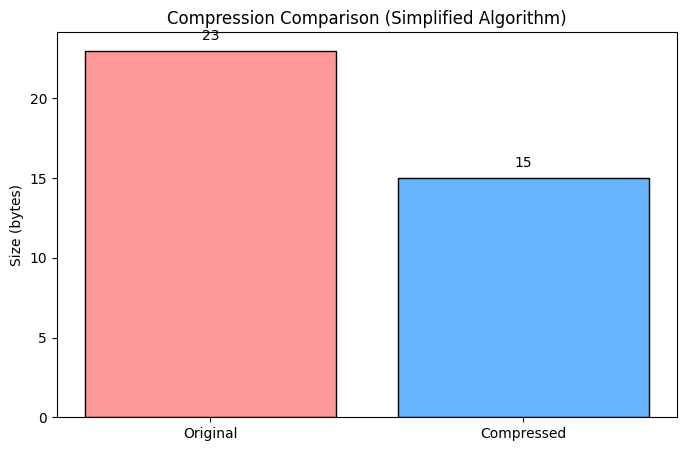

In [5]:
def main():
    print("Enter numeric sensor readings separated by spaces:")
    try:
        user_input = input(">> ")
            
        # Convert string input to list of integers
        data = [int(x) for x in user_input.strip().split()]
        
    except ValueError:
        print("Invalid input. Please enter numbers only.")
        return

    # --- Run Compression ---
    sequences = find_matches_and_compress(data)
    
    # --- Run Decompression ---
    decompressed_data = decompress_sequences(sequences)
    
    # --- Calculate Stats ---
    original_size = len(data) # Assuming 1 byte per reading for simplicity
    compressed_size = calculate_compressed_size(sequences)
    
    # Prevent division by zero
    if compressed_size > 0:
        ratio = original_size / compressed_size
    else:
        ratio = 0

    # --- Format Output ---
    print("\n--- RESULTS (Zstandard Manual - Sensor Data) ---")
    
    # 1. Original Sequence
    print(f"Original Sensor Sequence: {' '.join(map(str, data))}")
    
    # 2. Compressed Representation
    # Formatting the internal sequence objects into a readable string
    rep_str_parts = []
    for s in sequences:
        lit_str = str(s['literals'])
        if s['match_len'] > 0:
            rep_str_parts.append(f"[Lit:{lit_str}, MatchLen:{s['match_len']}, Off:{s['offset']}]")
        else:
             rep_str_parts.append(f"[Lit:{lit_str}]")
    print(f"Compressed Representation: {' -> '.join(rep_str_parts)}")

    # 3. Decompressed Output
    print(f"Decompressed Output: {' '.join(map(str, decompressed_data))}")
    
    # 4. Bytes & Ratio
    print(f"Original Bytes: {original_size}")
    print(f"Compressed Bytes: {compressed_size}")
    print(f"Compression Ratio: {ratio:.2f}")
    
    # --- Visualization ---
    plt.figure(figsize=(8, 5))
    labels = ['Original', 'Compressed']
    values = [original_size, compressed_size]
    colors = ['#ff9999','#66b3ff']
    
    bars = plt.bar(labels, values, color=colors, edgecolor='black')
    
    plt.ylabel('Size (bytes)')
    plt.title('Compression Comparison (Simplified Algorithm)')
    
    # Add value labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 1), ha='center', va='bottom')
        
    plt.show()

if __name__ == "__main__":
    main()

Enter numeric sensor readings separated by spaces:


>>  25 25 25 26 26 27 27 27 28 28 28 28 29



--- RESULTS (Zstandard Manual - Sensor Data) ---
Original Sensor Sequence: 25 25 25 26 26 27 27 27 28 28 28 28 29
Compressed Representation: [Lit:[25, 25, 25, 26, 26, 27, 27, 27, 28], MatchLen:3, Off:1] -> [Lit:[29]]
Decompressed Output: 25 25 25 26 26 27 27 27 28 28 28 28 29
Original Bytes: 13
Compressed Bytes: 16
Compression Ratio: 0.81


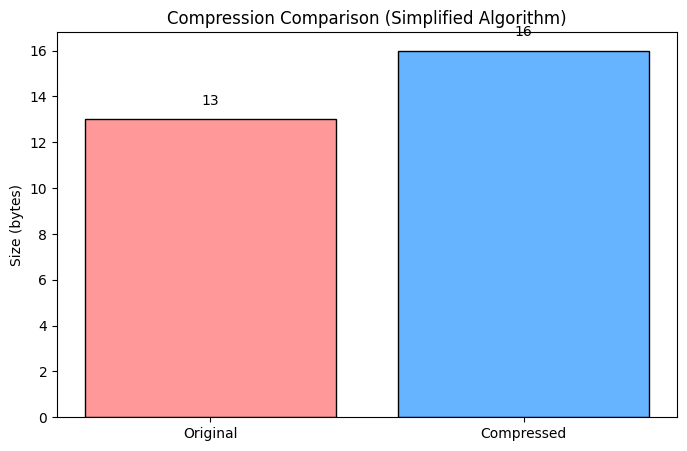

In [7]:
main()

Enter numeric sensor readings separated by spaces:


>>  1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 6 7 8 9 6 7 8 9



--- RESULTS (Zstandard Manual - Sensor Data) ---
Original Sensor Sequence: 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 6 7 8 9 6 7 8 9
Compressed Representation: [Lit:[1, 2, 3, 4, 5], MatchLen:10, Off:5] -> [Lit:[6, 7, 8, 9], MatchLen:4, Off:4]
Decompressed Output: 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 6 7 8 9 6 7 8 9
Original Bytes: 23
Compressed Bytes: 15
Compression Ratio: 1.53


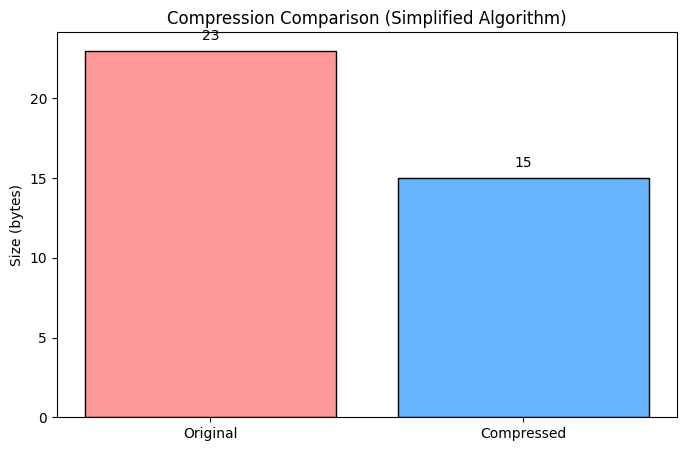

In [8]:
main()

Enter numeric sensor readings separated by spaces:


>>  5 6 7 8 5 6 7 8 5 6 7 8 5 6 7 8



--- RESULTS (Zstandard Manual - Sensor Data) ---
Original Sensor Sequence: 5 6 7 8 5 6 7 8 5 6 7 8 5 6 7 8
Compressed Representation: [Lit:[5, 6, 7, 8], MatchLen:12, Off:4]
Decompressed Output: 5 6 7 8 5 6 7 8 5 6 7 8 5 6 7 8
Original Bytes: 16
Compressed Bytes: 7
Compression Ratio: 2.29


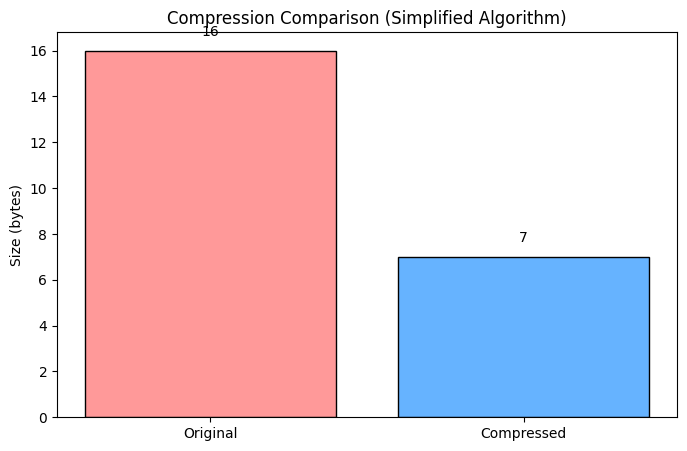

In [9]:
main()

Enter numeric sensor readings separated by spaces:


>>  10 11 12 10 11 12 10 11 12 10 11 12



--- RESULTS (Zstandard Manual - Sensor Data) ---
Original Sensor Sequence: 10 11 12 10 11 12 10 11 12 10 11 12
Compressed Representation: [Lit:[10, 11, 12], MatchLen:9, Off:3]
Decompressed Output: 10 11 12 10 11 12 10 11 12 10 11 12
Original Bytes: 12
Compressed Bytes: 6
Compression Ratio: 2.00


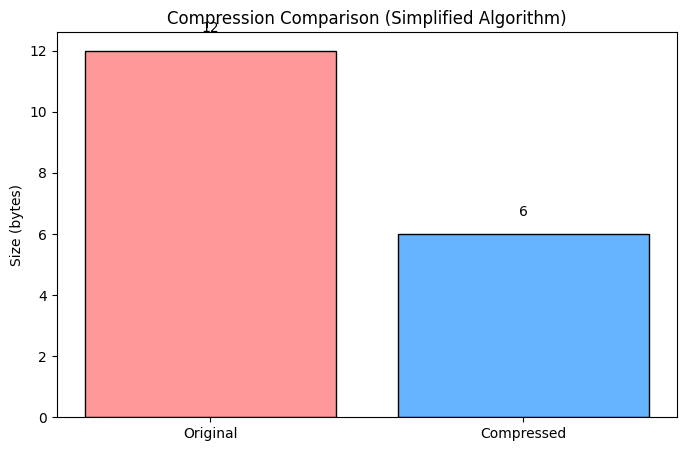

In [10]:
main()